In [92]:
from os.path import dirname, basename, exists, expanduser, join
from glob import glob

import matplotlib.pyplot as plt

import rasterio
import rasterio as rio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [84]:
def reproject_to_match(img_to_repro, ref_img, out_fp):
    kwargs = img_to_repro.meta.copy()
    kwargs.update({
        'crs': ref_img.crs,
        'transform': ref_img.transform,
        'width': ref_img.width,
        'height': ref_img.height
    })

    with rasterio.open(out_fp, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(img_to_repro, 1),
            destination=rasterio.band(dst, 1),
            src_transform=img_to_repro.transform,
            src_crs=img_to_repro.crs,
            dst_transform=ref_img.transform,
            dst_crs=ref_img.crs,
            resampling=Resampling.nearest)

    return out_fp

def get_dates(fp):
    return jpl_dic[basename(fp).split('.')[0]]

def add_extension(fp, new_ext):
    old_ext = fp.split('.')[-1]
    return join(dirname(fp) , basename(fp.replace(old_ext, f'{new_ext}.{old_ext}')))

In [48]:
data_dir = '/scratch/zacharykeskinen'
jpl_dic = {'lowman_23205_20002-007_20007-003_0013d_s01_L090HH_01':('2020-01-31','2020-02-13'),'lowman_23205_20007-003_20011-003_0008d_s01_L090HH_01':('2020-02-13','2020-02-21'),'lowman_23205_20011-003_20016-004_0019d_s01_L090HH_01':('2020-02-21','2020-03-11')}
jpl_unw = glob(join(data_dir, 'jpl','*', 'tiffs', '*HH*unw.grd.tiff'))
jpl_unw = [i for i in jpl_unw if basename(i).split('.')[0] in jpl_dic.keys()]
jpl_cor = glob(join(data_dir, 'jpl','*', 'tiffs', '*HH*cor.grd.tiff'))
jpl_cor = [i for i in jpl_cor if basename(i).split('.')[0] in jpl_dic.keys()]
isce_unw = glob(join(data_dir, 'isce','*','*unw.tif'))
isce_cor = glob(join(data_dir, 'isce','*','*cor.tif'))

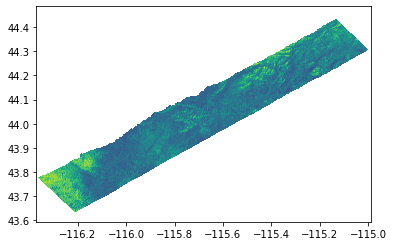

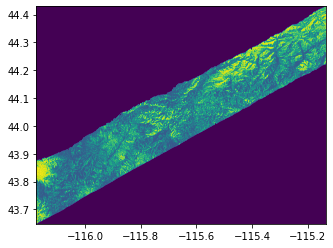

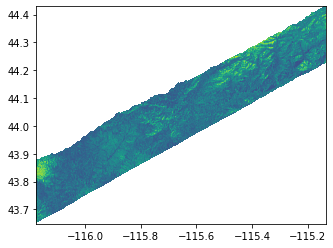

In [88]:
with rio.open(jpl_cor[0]) as src:
    dates = get_dates(jpl_cor[0])
    date0 = dates[0].replace('-','')
    date1 = dates[1].replace('-','')
    isce_fp = f'/scratch/zacharykeskinen/isce/{date0}_{date1}/merged_{date0}_{date1}.cor.tif'
    show(src)
    with rio.open(isce_fp) as src2:
        show(src2)
        isce = src2.read(1)
        out_fp = add_extension(jpl_cor[0], 'isce.repro')
        out_fp = reproject_to_match(src, src2, out_fp)
with rio.open(out_fp) as src_match:
    jpl = src_match.read(1)
    show(src_match)


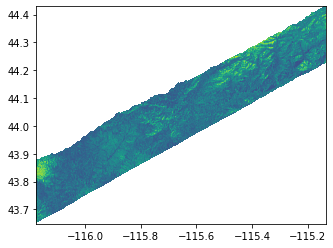

In [110]:
f, ax = plt.subplots()
with rio.open(out_fp) as src_match:
    jpl = src_match.read(1)
    show(src_match, ax = ax)
    x_labs = ax.get_xticklabels()
    x_locs = ax.get_xticks()
    y_locs = ax.get_yticks()

In [113]:
diff = isce - jpl
f, ax = plt.subplots(1, 3, figsize = (12,18))
ax[0].imshow(isce,  extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]), vmax = 1, vmin = 0)
ax[1].imshow(jpl,  extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]), vmax = 1, vmin = 0)
im = ax[2].imshow(diff, vmax = 0.5, vmin = -0.5,  extent = (x_locs[0], x_locs[-1], y_locs[0], y_locs[-1]))
# add space for colour bar
f.subplots_adjust(right=0.85)
cbar_ax = f.add_axes([0.88, 0.15, 0.04, 0.7])
f.colorbar(im, cax=cbar_ax)